In [1]:
import yaml

with open('config.yaml', 'r') as file:
    config = yaml.safe_load(file)

N = config["rnn"]["simulation"]["N"]
timesteps = config["rnn"]["simulation"]["timesteps"]
dt = config["rnn"]["simulation"]["dt"]
alpha = config["rnn"]["simulation"]["alpha"]
beta = config["rnn"]["simulation"]["beta"]

seed = config["rnn"]["model"]["seed"]
train_size = config["rnn"]["model"]["train_size"]
val_size = config["rnn"]["model"]["val_size"]
test_size = config["rnn"]["model"]["test_size"]

loss = config["rnn"]["training"]["loss"]
save = config["rnn"]["data"]["save"]
load = config["rnn"]["data"]["load"]

optimization_steps = config["gridsearch"]["optimization_steps"]
hyperparameters = config["gridsearch"]["hyperparameters"]

In [2]:
import numpy as np
from functions import Simulation as SIM
from functions import MachineLearning as ML
import os

# Specify the folder path
folder_path = r"D:/School/Magistrska/data"

q_i = np.sin(np.linspace(0, np.pi*2, N))
p_i = np.zeros(N)

sim = SIM(q_i, p_i, N, timesteps, dt)

# Check if the folder is empty
if len(os.listdir(folder_path)) == 0:
    print("No saved data, running simulation.")

    qs, ps = sim.integrate(alpha, beta)
    
else:
    print("Found some saved data, skipping simulation.")
    
    qs = np.load(folder_path+"\data_qs_1.npy")
    ps = np.load(folder_path+"\data_ps_1.npy")
    
qs = qs[:, 1:-1]
ps = ps[:, 1:-1]

Found some saved data, skipping simulation.


In [3]:
from sklearn.model_selection import ParameterGrid

all_parameter_comb = ParameterGrid(hyperparameters)
print(len(all_parameter_comb))

384


In [4]:
# Randomize the order of the gridsearch
# random.seed(seed)

all_parameter_comb = random.sample(list(all_parameter_comb), optimization_steps)

In [5]:
import tensorflow as tf
tf.random.set_seed(seed)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Dropout, GRU

def build_model(learning_rate, hidden_units_per_layer, dropout, window_size):
    
    initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=seed)

    model = Sequential()
    model.add(InputLayer((window_size, N-2)))
    
    model.add(GRU(hidden_units_per_layer, activation="tanh", kernel_initializer=initializer))
     
    if dropout != 0:
        model.add(Dropout(dropout, seed=seed))
        
    model.add(Dense(N-2, kernel_initializer=initializer))
    
    optimizer = tf.keras.optimizers.Adam(learning_rate)
    
    model.compile(loss="mse", optimizer=optimizer)

    return model

Best Parameters: {'batch_size': 30, 'dropout': 0.01, 'epochs': 50, 'hidden_units_per_layer': 6, 'learning_rate': 0.005, 'window_size': 8}
Best mse: 1.0329875982127872


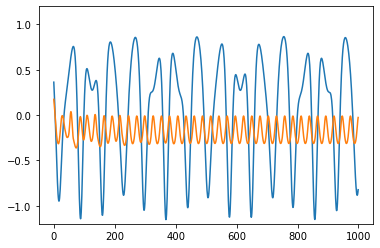


 Completed:  1 / 200
-------------------------------------------------------------
Best Parameters: {'batch_size': 15, 'dropout': 0.01, 'epochs': 50, 'hidden_units_per_layer': 9, 'learning_rate': 0.01, 'window_size': 6}
Best mse: 1.020427318186197


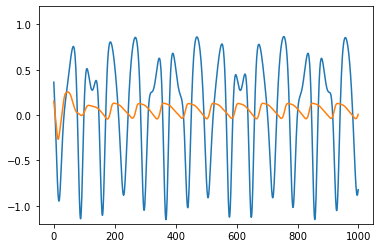


 Completed:  2 / 200
-------------------------------------------------------------

 Completed:  3 / 200
-------------------------------------------------------------

 Completed:  4 / 200
-------------------------------------------------------------

 Completed:  5 / 200
-------------------------------------------------------------

 Completed:  6 / 200
-------------------------------------------------------------

 Completed:  7 / 200
-------------------------------------------------------------

 Completed:  8 / 200
-------------------------------------------------------------

 Completed:  9 / 200
-------------------------------------------------------------

 Completed:  10 / 200
-------------------------------------------------------------

 Completed:  11 / 200
-------------------------------------------------------------

 Completed:  12 / 200
-------------------------------------------------------------

 Completed:  13 / 200
--------------------------------------------------

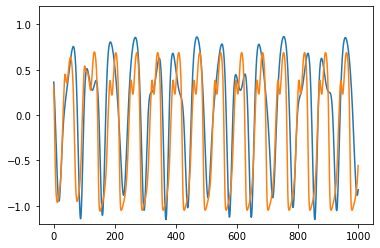


 Completed:  36 / 200
-------------------------------------------------------------

 Completed:  37 / 200
-------------------------------------------------------------

 Completed:  38 / 200
-------------------------------------------------------------

 Completed:  39 / 200
-------------------------------------------------------------

 Completed:  40 / 200
-------------------------------------------------------------

 Completed:  41 / 200
-------------------------------------------------------------

 Completed:  42 / 200
-------------------------------------------------------------

 Completed:  43 / 200
-------------------------------------------------------------

 Completed:  44 / 200
-------------------------------------------------------------

 Completed:  45 / 200
-------------------------------------------------------------

 Completed:  46 / 200
-------------------------------------------------------------

 Completed:  47 / 200
------------------------------------------

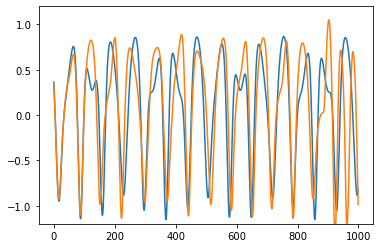


 Completed:  81 / 200
-------------------------------------------------------------

 Completed:  82 / 200
-------------------------------------------------------------

 Completed:  83 / 200
-------------------------------------------------------------

 Completed:  84 / 200
-------------------------------------------------------------

 Completed:  85 / 200
-------------------------------------------------------------

 Completed:  86 / 200
-------------------------------------------------------------

 Completed:  87 / 200
-------------------------------------------------------------

 Completed:  88 / 200
-------------------------------------------------------------

 Completed:  89 / 200
-------------------------------------------------------------

 Completed:  90 / 200
-------------------------------------------------------------

 Completed:  91 / 200
-------------------------------------------------------------

 Completed:  92 / 200
------------------------------------------

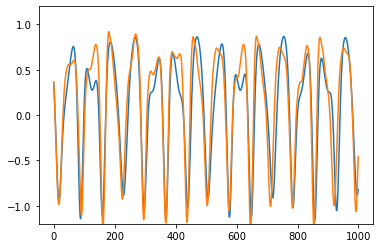


 Completed:  121 / 200
-------------------------------------------------------------

 Completed:  122 / 200
-------------------------------------------------------------

 Completed:  123 / 200
-------------------------------------------------------------

 Completed:  124 / 200
-------------------------------------------------------------

 Completed:  125 / 200
-------------------------------------------------------------

 Completed:  126 / 200
-------------------------------------------------------------

 Completed:  127 / 200
-------------------------------------------------------------

 Completed:  128 / 200
-------------------------------------------------------------

 Completed:  129 / 200
-------------------------------------------------------------

 Completed:  130 / 200
-------------------------------------------------------------

 Completed:  131 / 200
-------------------------------------------------------------

 Completed:  132 / 200
------------------------------

In [6]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import json

best_mse = np.inf
best_params = {}
best_model = None
best_pred = []

iteration = 1

for params in all_parameter_comb:
    
    X, y = ML.make_sequences(ML.preprocess(qs), params["window_size"])

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=val_size, shuffle=False)
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=test_size/(1-val_size), shuffle=False)

    from tensorflow.keras.callbacks import ModelCheckpoint

    # Create the ModelCheckpoint callback
    model_checkpoint_callback = ModelCheckpoint(filepath=(r'D:/School/Magistrska/best_model_RNN/gridsearch_temp.h5'), monitor='val_loss', save_best_only=True, mode='min', verbose=0)

    model = build_model(params["learning_rate"], params["hidden_units_per_layer"], params["dropout"], params["window_size"])

    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=params["epochs"], batch_size=params["batch_size"], callbacks=[model_checkpoint_callback], verbose = 0)
    
    model = tf.keras.models.load_model(r'D:/School/Magistrska/best_model_RNN/gridsearch_temp.h5')
    
    test_pred = np.copy(X_test[0])
    for k in range(len(X_test)):
        pred = model.predict(test_pred[np.newaxis, -params["window_size"]:], verbose=0)
        test_pred = np.concatenate((test_pred, pred), axis = 0)
        
    test_pred = test_pred[params["window_size"]:]

    mse = mean_squared_error(ML.postprocess(y_test), ML.postprocess(test_pred))

    if mse < best_mse:
        best_mse = mse
        best_params = params
        best_model = model
        best_pred = test_pred

        print("Best Parameters:", best_params)
        print("Best mse:", best_mse)
        
        plt.plot(ML.postprocess(y_test)[:, 2], color="tab:blue")
        plt.plot(ML.postprocess(test_pred)[:, 2], color="tab:orange")
        plt.ylim(-1.2, 1.2)
        plt.show()
        
        # Save on each step in case of crash        
        best_model.save(r'D:/School/Magistrska/best_model_RNN/gridsearch_1.h5')
        
        np.save(r'D:/School/Magistrska/best_model_RNN/best_pred_1.npy', best_pred)

        with open(r'D:/School/Magistrska/best_model_RNN/best_params_1.json', 'w') as config_file:
            json.dump(best_params, config_file)
        
    print("\n Completed: ", iteration, "/", len(all_parameter_comb))
    print("-------------------------------------------------------------")

    iteration += 1

In [7]:
# Use the optimal parameters to build the model
optimal_model = tf.keras.models.load_model(r"D:/School/Magistrska/best_model_RNN/gridsearch_1.h5")
# optimal_model.set_weights(best_model.get_weights())

with open(r"D:/School/Magistrska/best_model_RNN/best_params_1.json", 'r') as config_file:
    best_params = json.load(config_file)
    
best_pred = np.load(r'D:/School/Magistrska/best_model_RNN/best_pred_1.npy')

In [8]:
X, y = ML.make_sequences(ML.preprocess(qs), best_params["window_size"])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=val_size, shuffle=False)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=test_size/(1-val_size), shuffle=False)

test_pred = np.copy(X_test[0])
for k in range(len(X_test)):
    pred = optimal_model.predict(test_pred[np.newaxis, -best_params["window_size"]:], verbose=0)
    test_pred = np.concatenate((test_pred, pred), axis=0)
    
test_pred = test_pred[best_params["window_size"]:]

mse = mean_squared_error(ML.postprocess(y_test), ML.postprocess(test_pred))

print("Optimal Parameters:", best_params)
print("Optimal mse:", mse)

Optimal Parameters: {'batch_size': 25, 'dropout': 0, 'epochs': 50, 'hidden_units_per_layer': 6, 'learning_rate': 0.005, 'window_size': 6}
Optimal mse: 0.20097339299966435


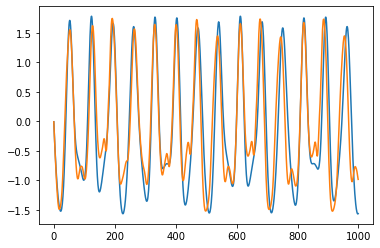

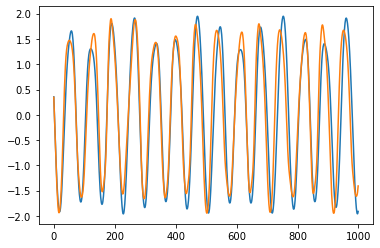

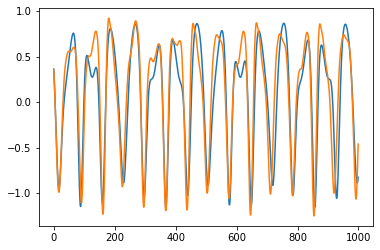

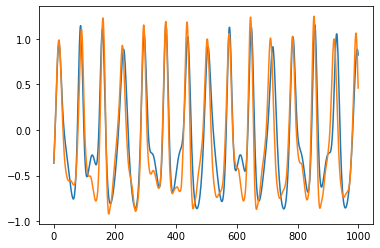

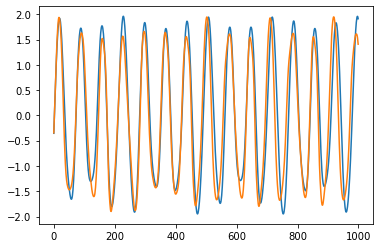

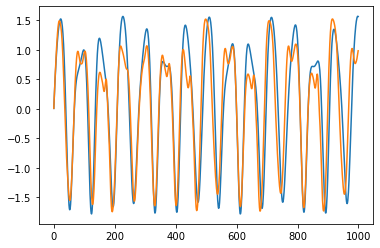

In [12]:
for particles in range(N-2):
    plt.plot(ML.preprocess(y_test)[:, particles], color="tab:blue")
    plt.plot(ML.postprocess(test_pred)[:, particles], color="tab:orange")
    # plt.plot(postprocess(best_pred)[:, particles], color="tab:red")
    # plt.ylim(-1.2, 1.2)
    plt.savefig("plot_particle_#"+str(particles)+".pdf", format='pdf')
    plt.show()